# Test 1 Prueba Data Science Capgemini
**Javier Crespo Guerrero** (javicrespi2000@gmail.com)

## Análisis Exploratorio

Análisis completo del dataset escogido, incluyendo visualización y justificación de las transformaciones a realizar previas a la selección del modelo

### El Dataset Escogido

He escogido el Dataset de clasificación [UCI Heart Disease Data (Kaggle)](https://www.kaggle.com/datasets/redwankarimsony/heart-disease-data/) donde tenemos que predecir la presencia de enfermedades cardiovasculares (0 = Sano 1 = Enfermo) a partir de una serie de indicadores (según la fuente):

- id (Unique id for each patient)
- age (Age of the patient in years)
- dataset (place of study)
- sex (Male/Female)
- cp chest pain type ([typical angina, atypical angina, non-anginal, asymptomatic])
- trestbps resting blood pressure (resting blood pressure (in mm Hg on admission to the hospital))
- chol (serum cholesterol in mg/dl)
- fbs (if fasting blood sugar > 120 mg/dl)
- restecg (resting electrocardiographic results)
- thalch: maximum heart rate achieved
- exang: exercise-induced angina (True/ False)
- oldpeak: (ST depression induced by exercise relative to rest)
- slope: (the slope of the peak exercise ST segment)
- ca: (number of major vessels [0-3] colored by fluoroscopy)
- thal: [normal; fixed defect; reversible defect]
- num: the predicted attribute

#### *¿Por qué este Dataset?*

He escogido este Dataset porque creo que representa un problema completo de clasificación, que incluye tanto variables categóricas como variables numéricas discretas y contínuas, así como datos missing que tendremos que imputar. De esta forma el Dataset se ajustaría más a la complejidad de un problema real pero con un tamaño asequible para este ejercicio.

In [1]:
# Carga de dependencias

# manipulacion de datasets
import pandas as pd
import numpy as np

# visualizacion
import matplotlib.pyplot as plt
import seaborn as sns

# transformaciones de datos
import scipy.stats as stats

# Parametros
FILE_PATH = '../data/heart_disease_uci.csv'

### Lectura del Dataset y comprobación de tipos y datos missing

In [2]:
data = pd.read_csv(FILE_PATH)
print(data.shape)
data.head()

(920, 16)


,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,1
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [3]:
# Eliminamos la variable ID, puesto que es solamente un identificador del paciente y no nos da ningún tipo de información
data.drop('id', axis=1, inplace=True)

Estamos ante un problema de clasificación binaria con 14 variables tanto numéricas como categóricas, con 920 individuos. Empecemos comprobando los tipos de las variables

In [4]:
data.dtypes

age           int64
sex          object
dataset      object
cp           object
trestbps    float64
chol        float64
fbs          object
restecg      object
thalch      float64
exang        object
oldpeak     float64
slope        object
ca          float64
thal         object
num           int64
dtype: object

Todos los tipos parecen correctos y se corresponden con lo indicado en la descripción del Datset. Disponemos de 8 variables categóricas y 6 numéricas. A continuación comprobaremos la presencia de valores missing.

In [5]:
data.isnull().mean().sort_values(ascending=False)

ca          0.664130
thal        0.528261
slope       0.335870
fbs         0.097826
oldpeak     0.067391
trestbps    0.064130
thalch      0.059783
exang       0.059783
chol        0.032609
restecg     0.002174
dataset     0.000000
cp          0.000000
age         0.000000
sex         0.000000
num         0.000000
dtype: float64

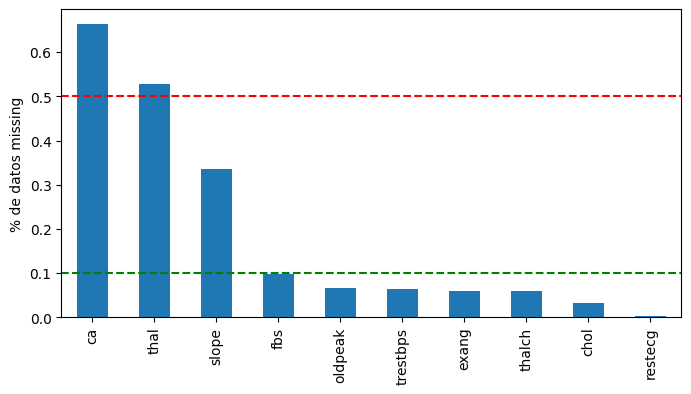

In [6]:
# visualizamos la frecuencia de missings
vars_with_missing = [var for var in data.columns if data[var].isnull().sum() > 0]
data[vars_with_missing].isnull().mean().sort_values(
    ascending=False).plot.bar(figsize=(8, 4))
plt.ylabel('% de datos missing')
plt.axhline(y=0.50, color='r', linestyle='dashed')
plt.axhline(y=0.10, color='g', linestyle='dashed')

Tenemos valores missing tanto en 5 variables categóricas (thal, slope, fbs, exang, restegc) como en 5 numéricas (ca, oldpeak, trestbps, thalch, chol). En algunos casos estos valores están vacíos para más el 50% de los individuos, por lo que la imputación de estos valores será una parte fundamental tanto del modelo como de su puesta en producción.

### La variable objetivo

A continuación vamos a analizar la distribución de nuestra variable objetivo

num
0    411
1    509
Name: count, dtype: int64


Text(0, 0.5, 'Numero de individuos')

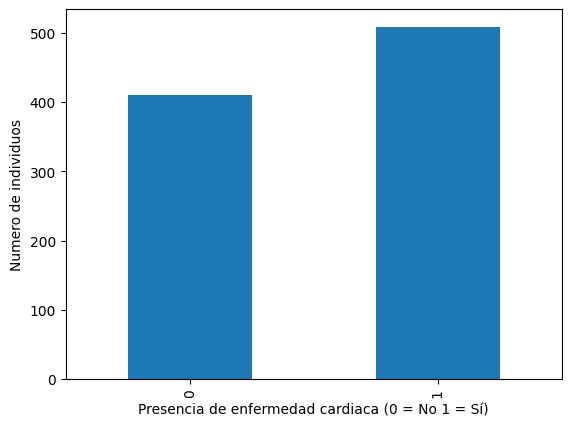

In [7]:
print(data['num'].value_counts().sort_index())
data['num'].value_counts().sort_index().plot.bar()
plt.xlabel('Presencia de enfermedad cardiaca (0 = No 1 = Sí)')
plt.ylabel('Numero de individuos')

En nuestra muestra hay 411 individuos sanos y 509 individuos con presencia de enfermedad cardiaca. En este caso las clases están desbalanceadas pero como la diferencia de individuos no es muy grande no supondrá un problema en la práctica.

### Variables categóricas

Vamos a empezar analizando las variables categóricas y su relación con la variable objetivo. Comenzaremos por la cardinalidad de éstas.

- dataset (place of study)
- sex (Male/Female)
- cp chest pain type ([typical angina, atypical angina, non-anginal, asymptomatic])
- fbs (if fasting blood sugar > 120 mg/dl)
- restecg (resting electrocardiographic results)
- exang: exercise-induced angina (True/ False)
- slope: (the slope of the peak exercise ST segment)
- thal: [normal; fixed defect; reversible defect]

<Axes: >

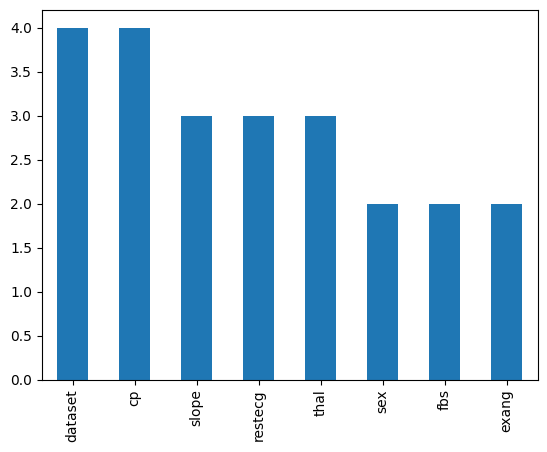

In [8]:
vars_cat = [var for var in data.columns if data[var].dtype == 'object']
vars_cat_with_missing = [var for var in vars_cat if var in vars_with_missing]

# Cardinalidad de las variables categóricas
data[vars_cat].nunique().sort_values(ascending=False).plot.bar()

El número de etiquetas es pequeño en todas las variables, por lo que a priori no deberían convertirse en un número demasiado alto de variables en el modelo final.

In [9]:
# Etiquetas y distribución dentro de cada variable
for var in vars_cat:
    print(data[var].value_counts())

sex
Male      726
Female    194
Name: count, dtype: int64
dataset
Cleveland        304
Hungary          293
VA Long Beach    200
Switzerland      123
Name: count, dtype: int64
cp
asymptomatic       496
non-anginal        204
atypical angina    174
typical angina      46
Name: count, dtype: int64
fbs
False    692
True     138
Name: count, dtype: int64
restecg
normal              551
lv hypertrophy      188
st-t abnormality    179
Name: count, dtype: int64
exang
False    528
True     337
Name: count, dtype: int64
slope
flat           345
upsloping      203
downsloping     63
Name: count, dtype: int64
thal
normal               196
reversable defect    192
fixed defect          46
Name: count, dtype: int64


No hay ninguna etiqueta que tenga un número de individuos especialmente pequeño, por lo que no nos tendremos que preocupar de los "Rare Labels" en este ejercicio.

#### Sexo y Lugar de estudio

Empezamos analizando la distribución del sexo (variable sex) y el lugar (variable dataset) donde se estudió al paciente, así como su relación con la variable objetivo.

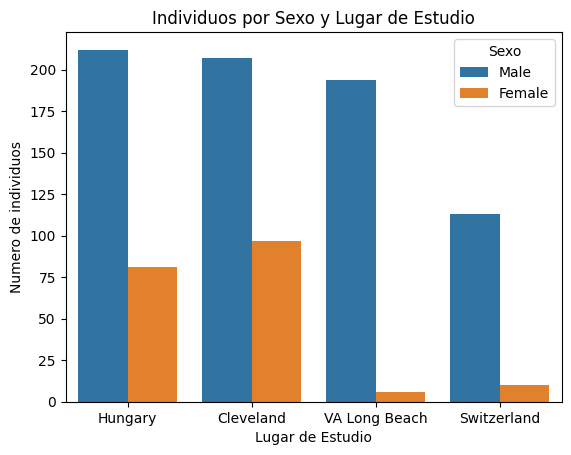

In [10]:
# Numero de individuos por país y sexo
count_data = data.value_counts(['dataset', 'sex']).reset_index(name='count')

sns.barplot(data=count_data, x='dataset', y='count', hue='sex' )
plt.title('Individuos por Sexo y Lugar de Estudio')
plt.xlabel('Lugar de Estudio')
plt.ylabel('Numero de individuos')
plt.legend().set_title("Sexo")

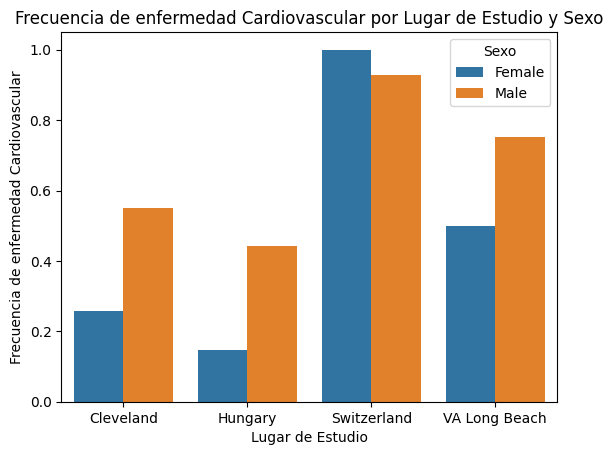

In [11]:
# Relación con la variable categórica
mean_data = data.groupby(['dataset', 'sex'], as_index=False)['num'].mean()

sns.barplot(data=mean_data, x='dataset', y='num', hue='sex' )
plt.title('Frecuencia de enfermedad Cardiovascular por Lugar de Estudio y Sexo')
plt.xlabel('Lugar de Estudio')
plt.ylabel('Frecuencia de enfermedad Cardiovascular')
plt.legend().set_title("Sexo")

En general, los hombres parecen más propensos que las mujeres a padecer enfermedades cardiovasculares. Del mismo modo, en territorios como Suiza la aparición de estas enfermedades parece más frecuente  que en otros territorios. También se podría intuir que hay interacción entre estas dos variables, puesto que las mujeres en Suiza parecen más propensas a la aparición de enfermedades cardiovasculares.

Parece que las variables *sex* y *dataset* pueden ser útiles a la hora de predecir nuestra variable objetivo. Sin embargo, no podemos afirmar las conclusiones anteriores de forma categórica puesto que la muestra es limitada en algunas combinaciones de sexo-territorio.

#### Indicadores médicos

Vamos a analizar el resto de variables correspondientes a indicadores médicos (*cp, fbs, restecg, exang, slope, thal*). Prestaremos especial atención a las etiquetas missing que haya en cada variable, por si su relación con la variable objetivo destacase con respecto al resto.

In [12]:
# Variables categóricas de indicadores médicos
medical_cat_vars = [var for var in vars_cat if var not in ['sex', 'dataset']]

# Reemplazamos los valores missing por un string para poder visualizarlos
data_missing_replaced = data.copy()
data_missing_replaced[['exang', 'fbs']] = data_missing_replaced[['exang', 'fbs']].astype(str)
data_missing_replaced[medical_cat_vars] = data_missing_replaced[medical_cat_vars].fillna('Missing')

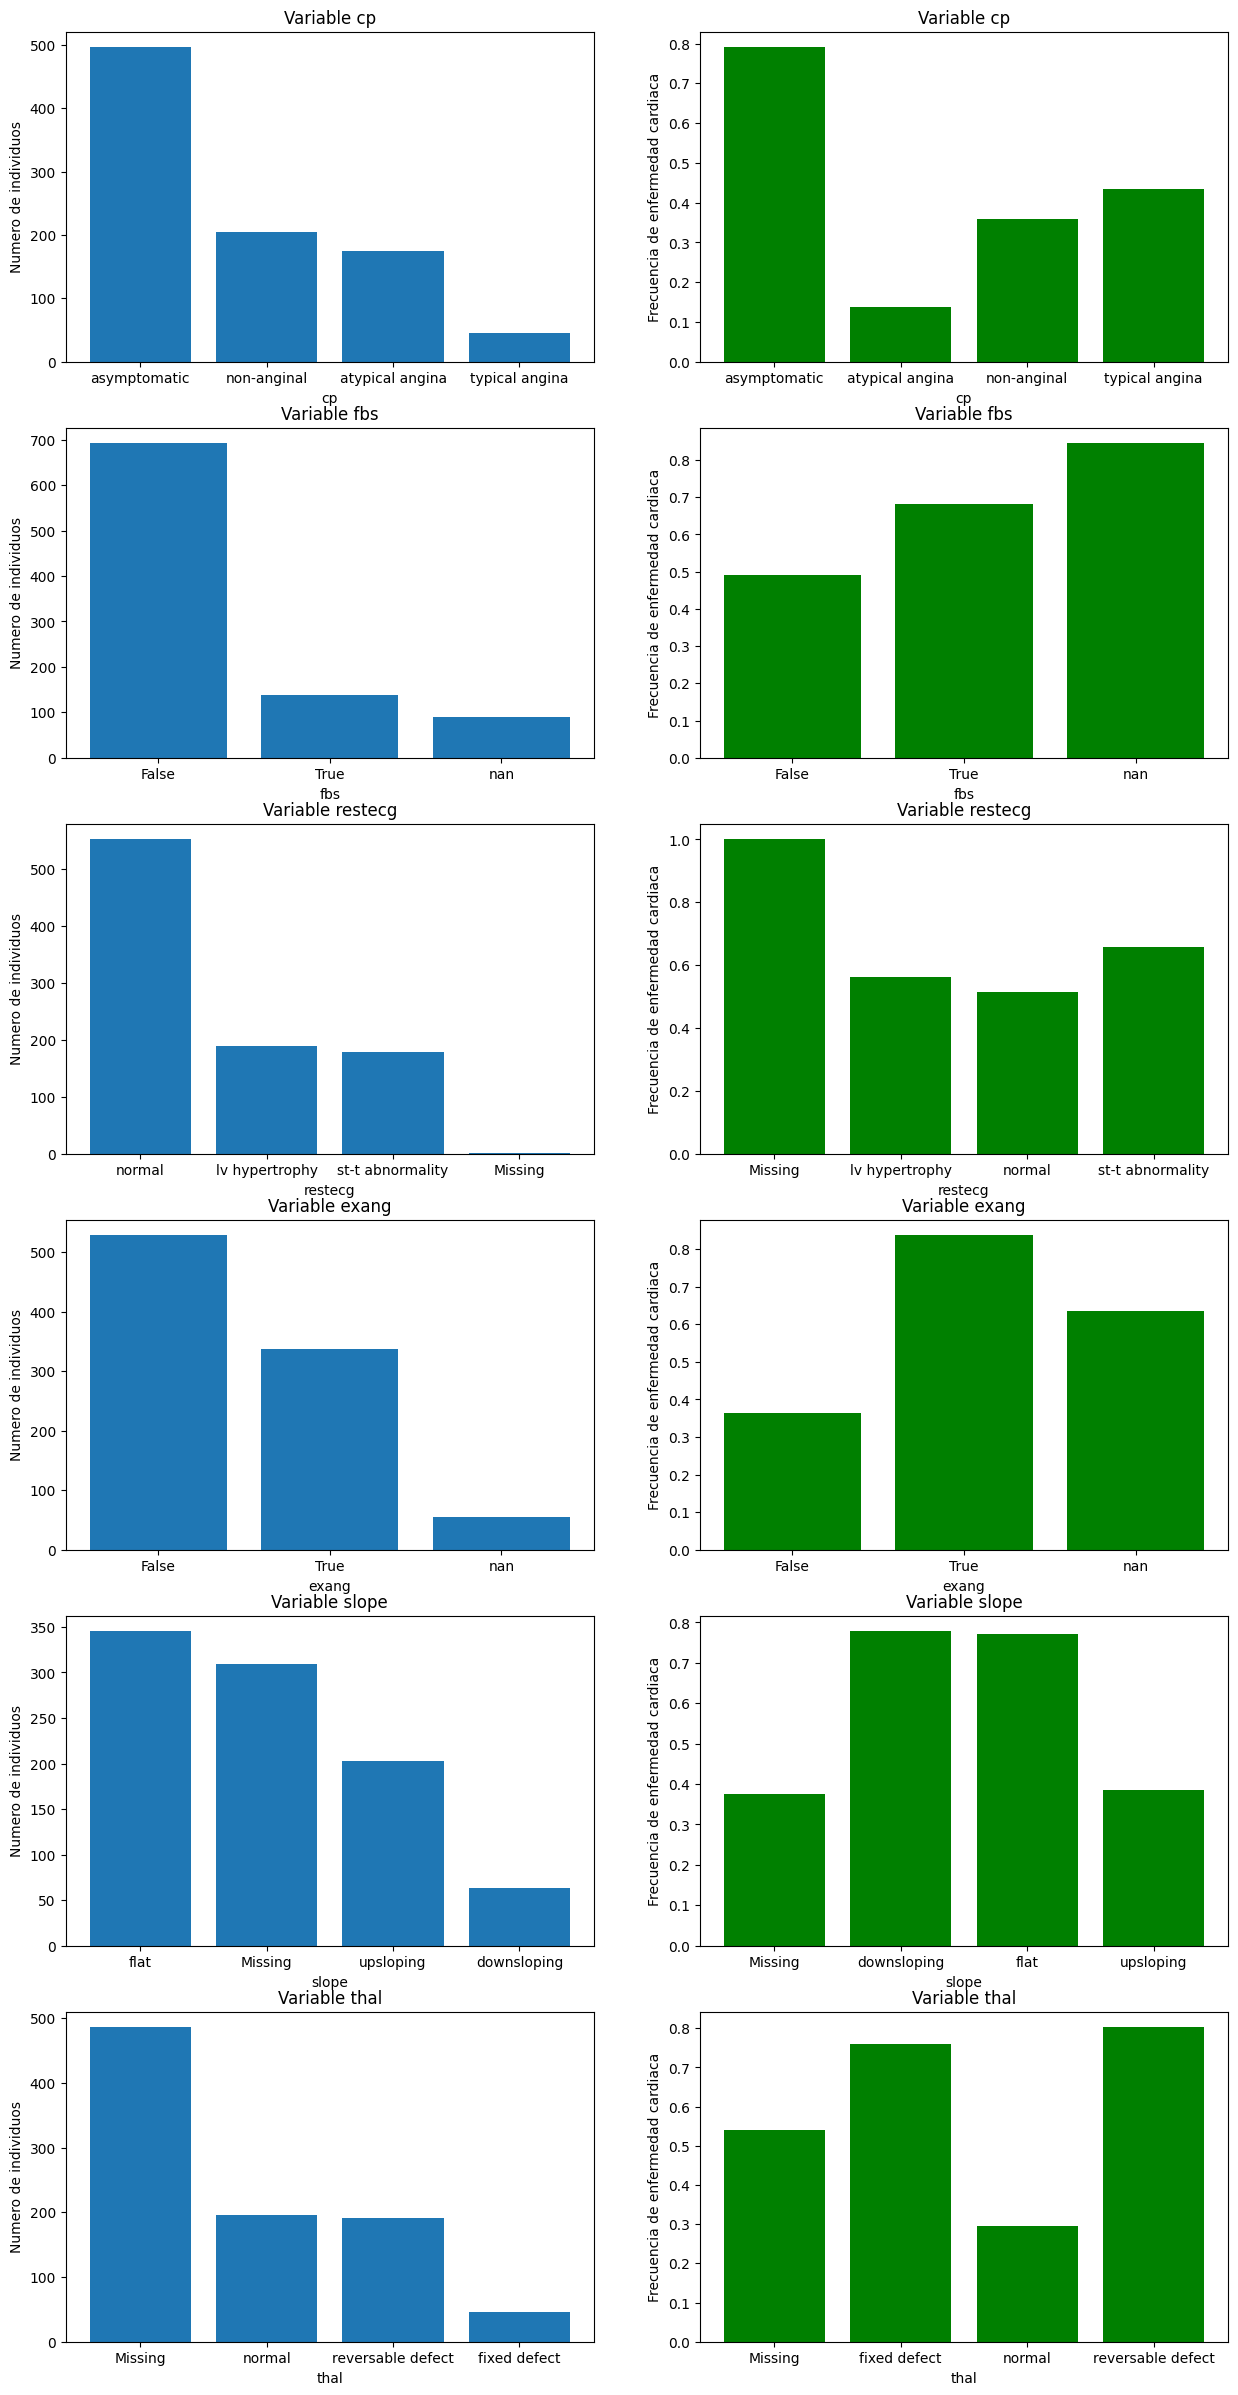

In [13]:
fig, axs = plt.subplots(6, 2)
fig.set_figheight(30)
fig.set_figwidth(15)

for var, i in zip(medical_cat_vars, range(6)):
   count_data = data_missing_replaced.value_counts([var]).reset_index(name='count')
   mean_data = data_missing_replaced.groupby([var], as_index=False)['num'].mean()
   
   axs[i, 0].bar(x=count_data[var], height=count_data['count'])
   axs[i, 0].set_xlabel(var)
   axs[i, 0].set_ylabel('Numero de individuos')
   axs[i, 0].set_title(f'Variable {var}')
   
   axs[i, 1].bar(x=mean_data[var], height=mean_data['num'], color = 'green')
   axs[i, 1].set_xlabel(var)
   axs[i, 1].set_ylabel('Frecuencia de enfermedad cardiaca')
   axs[i, 1].set_title(f'Variable {var}')
   
plt.show()

Sin entrar al detalle de cada variable, podemos ver que en general todas reflejan diferencias en la frecuencia de enfermedad cardiaca para las distintas etiquetas. Cabe destacar que en algunos casos (por ejemplo la variable *slope*) el no disponer de datos parece estar relacionado con valores mayores o menores de la variable objetivo, por lo que en la imputación de estos datos parece razonable el añadir una variable adicional indicando si el dato estaba Missing.

### Variables Numéricas

A continuación vamos a estudiar la distribución de las variables numéricas y las posibles transformaciones a realizar

- age (Age of the patient in years)
- trestbps resting blood pressure (resting blood pressure (in mm Hg on admission to the hospital))
- chol (serum cholesterol in mg/dl)
- thalch: maximum heart rate achieved
- exang: exercise-induced angina (True/ False)
- oldpeak: (ST depression induced by exercise relative to rest)
- slope: (the slope of the peak exercise ST segment)
- ca: (number of major vessels [0-3] colored by fluoroscopy)
- thal: [normal; fixed defect; reversible defect]

In [14]:
# Variables numericas
vars_num = [var for var in data.columns if var not in vars_cat and var != 'num']
vars_num

['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']

#### Variables discretas

Vamos a comenzar analizando la distibución de las variables discretas y su relación con la variable objetivo

In [15]:
vars_discrete = [var for var in vars_num if len(data[var].unique()) < 20]
vars_discrete

['ca']

En este caso la única variable discreta que hay es *ca*, que puede tomar los valores de 0 a 3 (o estar vacía). Vamos a estudiar su distribución y relación con la variable objetivo.

Text(0, 0.5, 'Frecuencia de enfermedad cardiaca')

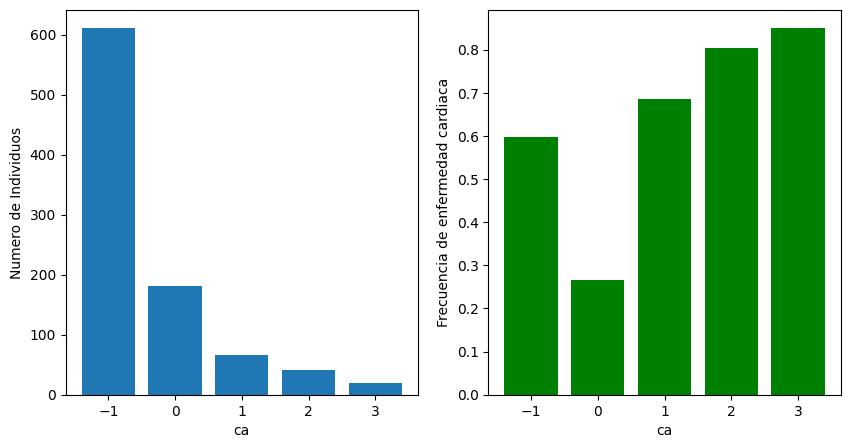

In [16]:
# Vamos a mostrar los missing utilizando -1 para poder mostrar su distribución
data_with_missings_labeled = data.copy()
data_with_missings_labeled['ca'] = data_with_missings_labeled['ca'].fillna(-1)
count_data = data_with_missings_labeled.value_counts(['ca']).reset_index(name='count')
mean_data = data_with_missings_labeled.groupby(['ca'], as_index=False)['num'].mean()

fig, axs = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(10)

axs[0].bar(x=count_data['ca'], height=count_data['count'])
axs[0].set_xlabel('ca')
axs[0].set_ylabel('Numero de Individuos')

axs[1].bar(x=mean_data['ca'], height=mean_data['num'], color = 'green')
axs[1].set_xlabel('ca')
axs[1].set_ylabel('Frecuencia de enfermedad cardiaca')

Parece que hay bastante correlación entre valores altos de la variable *ca* y mayor presencia de enfermedades cardiacas. La distribución para los valores missing parece quedarse en la media de los datos, por lo que usar la media o la mediana como inputador de los datos vacíos parece razonable.

#### Variables continuas

Por último, vamos a analizar las variables continuas

In [17]:
vars_cont = [var for var in vars_num if var not in vars_discrete]
vars_cont

['age', 'trestbps', 'chol', 'thalch', 'oldpeak']

Primero estudiamos la distribución de las variables, por si fuera necesario realizar alguna transformación

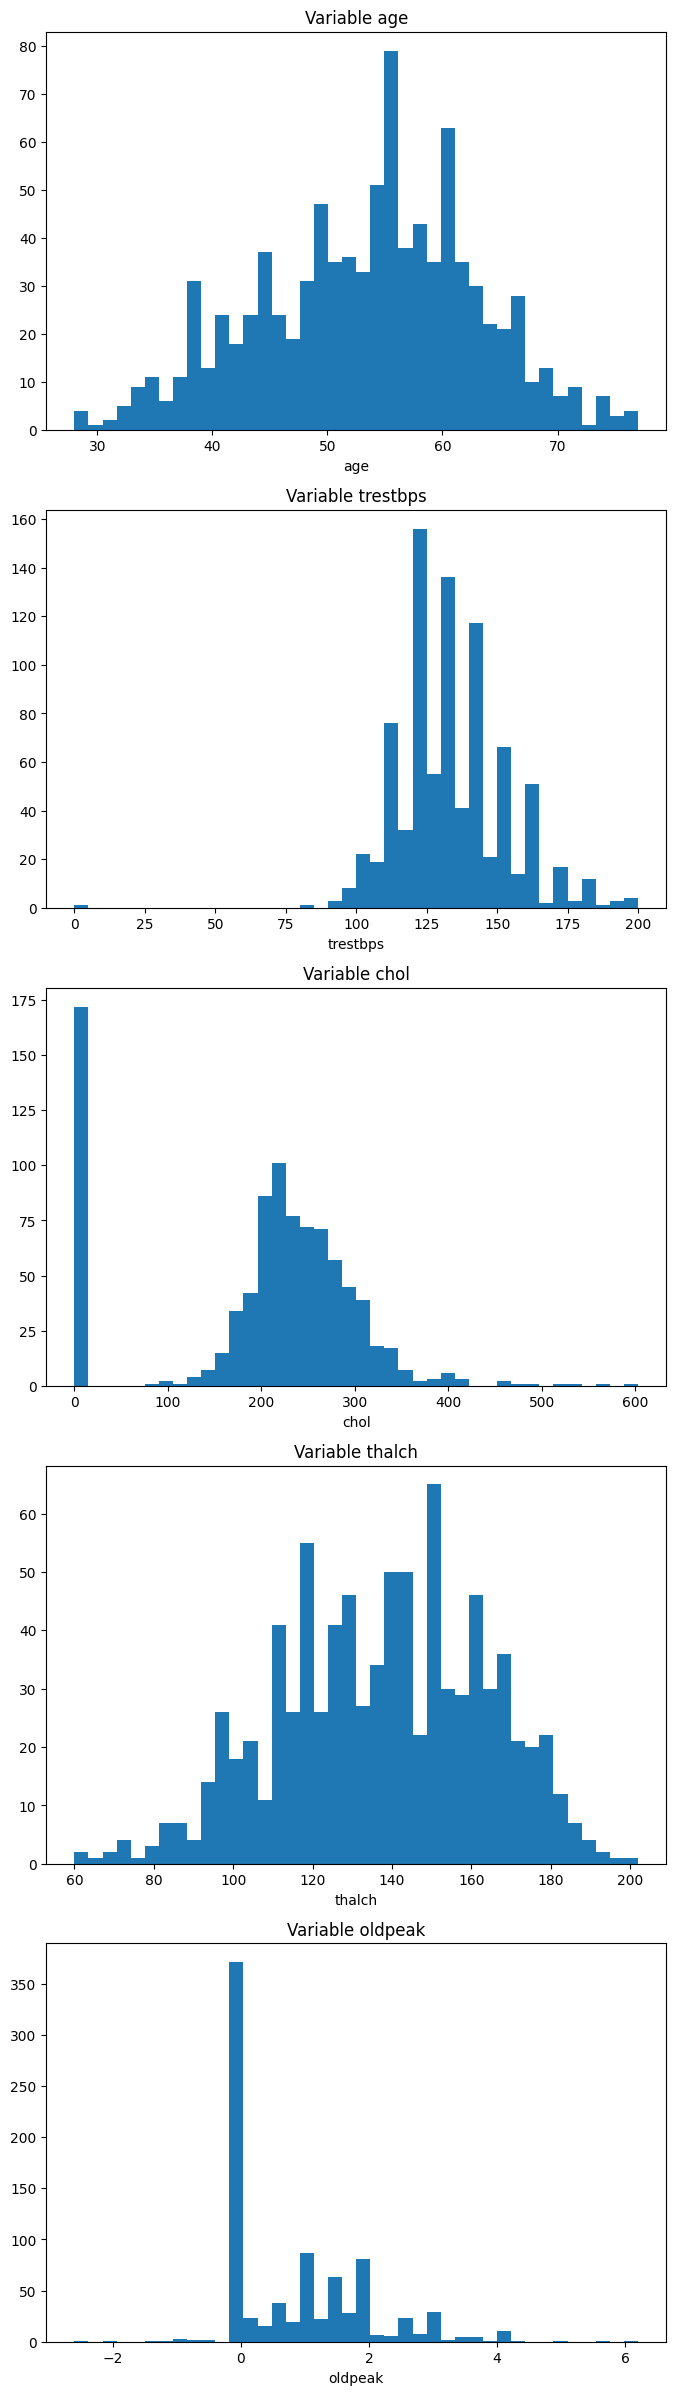

In [18]:
fig, axs = plt.subplots(5, 1)
fig.set_figheight(30)
fig.set_figwidth(8)

for var, i in zip(vars_cont, range(5)):
    axs[i].hist(x = data[var], bins=40)
    axs[i].set_xlabel(var)
    # axs[i].set_ylabel('Numero de individuos')
    axs[i].set_title(f'Variable {var}')

Las variables *age, thalch* parecen seguir una distribución similar a la normal.

La variable *trestbps* parece tener sesgo, con más peso en el lado derecho de la distribución. Vamos a probar una transformación logarítmica de esta variable para ver si podemos distribuir más uniformemente la distribución y mejorar nuestras predicciones. Vemos que hay un valor 0 en la distribución, como no es realista pensar que la presión sanguínea pueda ser 0, vamos a marcarlo como dato missing.

Las variable *chol* mide el colesterol en sangre. No es realista poder tener valores de 0 como colesterol, por lo que asumimos que estos datos están missing y tendremos que inputarlos. Aún así, si nos fijamos en los datos que no son 0, podemos ver que también tenemos sesgo en la distribución, por lo que de nuevo probaremos con la transformación logarítmica para ver si podemos mejorar nuestras predicciones.

Por último, la variable *oldpeak* tiene una distribución marcada por los ceros. Como no tenemos mucho contexto sobre esta variable, vamos a estudiar la transformación de Yeo-Johsnon, diseñada para trabajar con ceros en la distribución.

A modo de primer análisis, vamos a estudiar visualmente la relación entre las variables y las transformaciones propuestas con la variable objetivo. Sin embargo, luego tendremos que determinar si finalmente realizamos las transformaciones basándonos en el rendimiento del modelo final.

<Axes: xlabel='age', ylabel='num'>

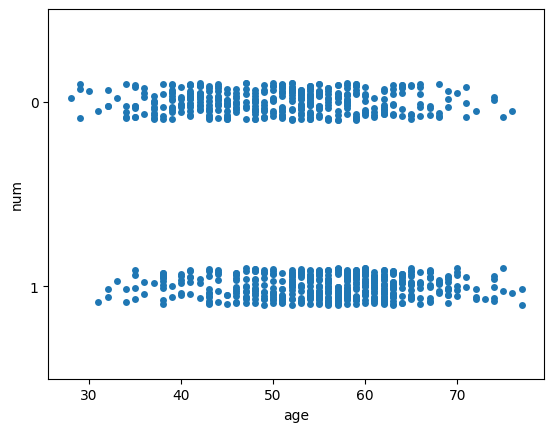

In [19]:
data_target_cat = data.copy() # Copiamos el dataframe para representar la variable objetivo como categórica
data_target_cat['num'] = data_target_cat['num'].astype('str')
sns.stripplot(x='age', y='num', data=data_target_cat, jitter=True)

Parece haber más presencia de enfermedad cardiovascular a mayor edad.

<Axes: xlabel='thalch', ylabel='num'>

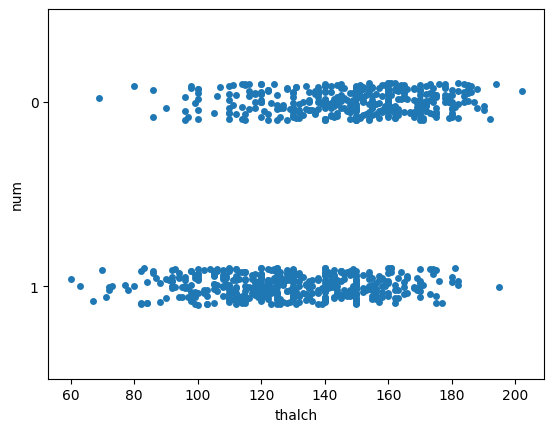

In [20]:
sns.stripplot(x='thalch', y='num', data=data_target_cat, jitter=True)

Aqui la relación parece ser la contraria, a más bajo *thalch* parece haber menor presencia de endermedad cardiovascular.

A continuación estudiaremos las variables *trestbps* y *chol*, así como sus posibles transformaciones logarítmicas para suavizar el sesgo.

In [21]:
# Aplicamos la transformación sobre la variable Chol
data['chol'] = data['chol'].replace(0, None)
data['trestbps'] = data['trestbps'].replace(0, None)

data_target_cat = data.copy() # Copiamos el dataframe para representar la variable objetivo como categórica
data_target_cat['num'] = data_target_cat['num'].astype('str')
# Para visualizar los datos, vamos a reemplazar los valores None en trestbps y chol por la media
data_target_cat['chol'] = data_target_cat['chol'].fillna(np.mean(data_target_cat['chol']))
data_target_cat['trestbps'] = data_target_cat['trestbps'].fillna(np.mean(data_target_cat['trestbps']))

/tmp/ipykernel_5337/4045690117.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_target_cat['chol'] = data_target_cat['chol'].fillna(np.mean(data_target_cat['chol']))
/tmp/ipykernel_5337/4045690117.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_target_cat['trestbps'] = data_target_cat['trestbps'].fillna(np.mean(data_target_cat['trestbps']))


In [22]:
data_target_cat['log_trestbps'] = np.log(data_target_cat['trestbps'])
data_target_cat['log_chol'] = np.log(data_target_cat['chol'])

<Axes: ylabel='Frequency'>

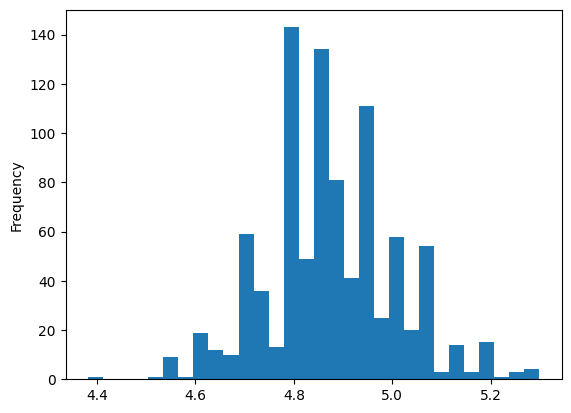

In [23]:
data_target_cat['log_trestbps'].plot.hist(bins = 30)

<Axes: xlabel='trestbps', ylabel='num'>

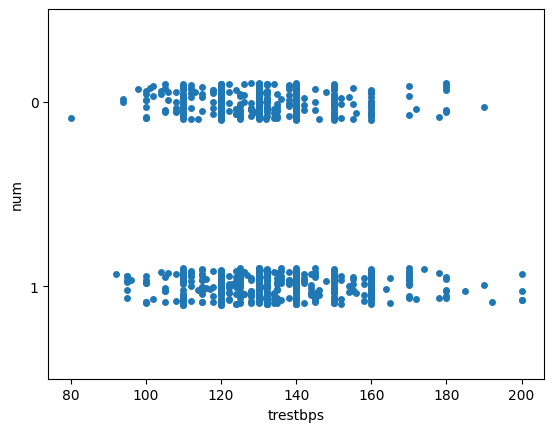

In [24]:
sns.stripplot(x='trestbps', y='num', data=data_target_cat, jitter=True)

<Axes: ylabel='Frequency'>

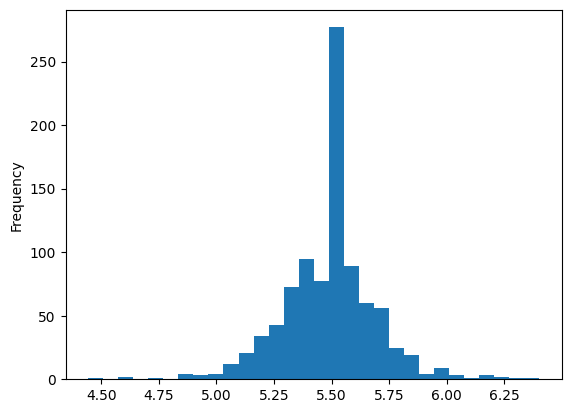

In [25]:
data_target_cat['log_chol'].plot.hist(bins = 30)

<Axes: xlabel='log_chol', ylabel='num'>

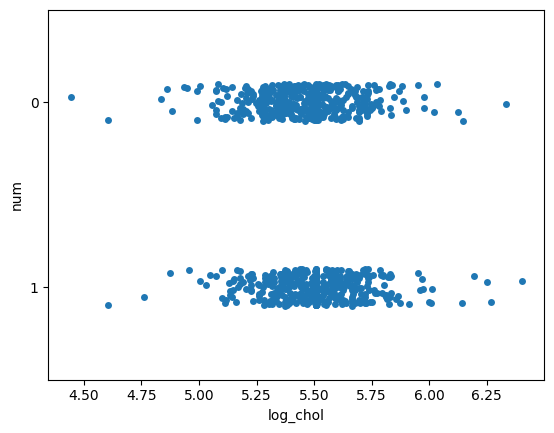

In [26]:
sns.stripplot(x='log_chol', y='num', data=data_target_cat, jitter=True)

Vemos que la transformación logarítmica suaviza bastante el sesgo de las distribuciones. Sin embargo, a simple vista no parece haber mucha relación directa con la variable respuesta en ambos casos, por lo que la decisión final recaerá sobre las métricas de evaluación del modelo.

Por último, vamos a estudiar la posibilidad de transformar la variable *oldpeak* con la transformación Yeo-Johnson

In [27]:
# De nuevo, reemplazamos los datos missing con la media para poder visualizar los datos
data_target_cat['oldpeak'] = data_target_cat['oldpeak'].fillna(np.mean(data['oldpeak']))
data_target_cat['yeojohnson_oldpeak'], param = stats.yeojohnson(data_target_cat['oldpeak'])

<Axes: ylabel='Frequency'>

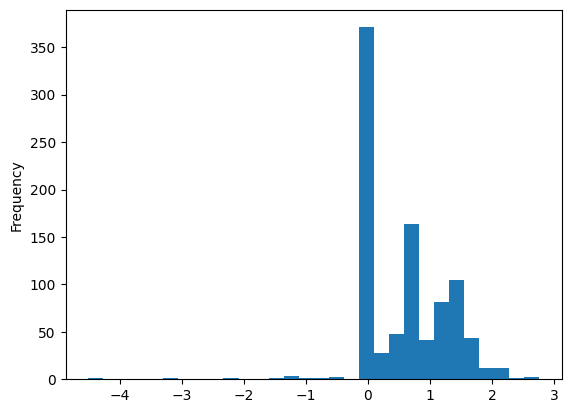

In [28]:
data_target_cat['yeojohnson_oldpeak'].plot.hist(bins = 30)

<Axes: xlabel='yeojohnson_oldpeak', ylabel='num'>

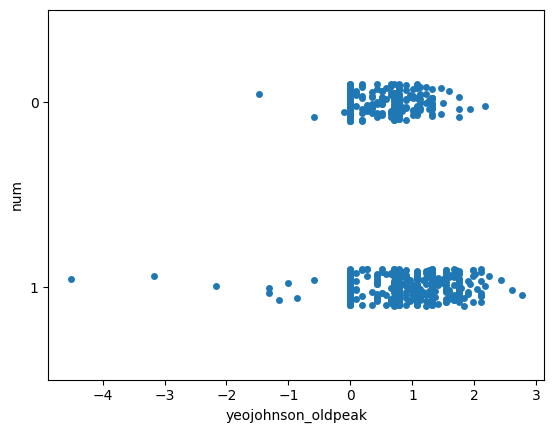

In [29]:
sns.stripplot(x='yeojohnson_oldpeak', y='num', data=data_target_cat, jitter=True)

La transdformación ha suavizado algo y sí que parece que hay cierta relación con la variable respuesta. Sin embargo, de nuevo, la decisión final recaerá sobre las métricas del modelo. También cabría la posibilidad de estudiar el crear un indicador de si esta variable es 0 o no e incluirlo en el modelo.

### Conclusiones

Tras este análisis nos hemos familiarizado con el problema y el dataset y estudiado las posibles transformaciones de datos que tendremos que llevar a cabo y estudiar. En general, la mayoría de variables parecen aportar información valiosa sobre la presencia de enfermedad cardiovascular. Por spuesto, podríamos realizar un análisis más extensivo estudiando, por ejemplo, la posible autocorrelación entre las variables. Pero en este caso no lo realizaremos por limitaciones de tiempo.

A modo de resumen, vamos a ir variable por variable estudiando las transformaciones e imputaciones que realizaremos a la hora de ajustar un modelo.

**Variables categóricas**
- dataset: sin datos missing. Codificaremos la variable como OneHot
- sex: sin datos missing. Codificaremos la variable como OneHot
- cp: sin datos missing. Codificaremos la variable como OneHot
- fbs: un 10% de datos missing. Añadiremos un indicador de si el dato es missing e inputaremos usando la categoría más frecuente. Codificaremos la variable como OneHot
- restecg: <1% de datos missing. Inputaremos usando la categoría más frecuente. Codificaremos la variable como OneHot
- exang: 6% de datos missing. Añadiremos un indicador de si el dato es missing e inputaremos usando la categoría más frecuente. Codificaremos la variable como OneHot
- slope: 34% de datos missing. Añadiremos un indicador de si el dato es missing e inputaremos añadiendo una nueva etiqueta. Codificaremos la variable como OneHot
- thal: 53% de datos missing. Añadiremos un indicador de si el dato es missing e inputaremos añadiendo una nueva etiqueta. Codificaremos la variable como OneHot

**Variables numéricas**
- ca: variable discreta, con 66% de missing. Usaremos la media/mediana para inputar.
- age: variable continua, sin datos missing. No estudiaremos ninguna transformación.
- thalch: variable continua, con un 6% de datos missing. Inputaremos usando la media, no estudiaremos ninguna transformación.
- trestbps: variable continua, con un 6% de datos missing. Consideraremos los ceros como missing. Inputaremos usando la media/mediana y estudiaremos la transformación logarítmica.
- chol: variable continua, con un 3% de datos missing. Consideraremos los ceros como missing. Inputaremos usando la media/mediana y estudiaremos la transformación logarítmica.
- oldpeak: variable continua, con un 7% de datos missing. Inputaremos usando la media/mediana y estudiaremos la transformación de Yeo-Johnson.

Con esto ya tenemos todo lo necesario para comenzar a buscar el modelo apropiado para este ejercicio.